In [1]:
import warnings
warnings.filterwarnings('ignore')

from utils import *
# data processing
import pandas as pd
import numpy as np

# image processing
from PIL import Image

# data visualization
import matplotlib.pyplot as plt
import seaborn as sn

# tf and keras
import tensorflow as tf
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization
from keras.layers.core import Dense, Activation, Flatten
from keras.optimizers import SGD, Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K

# dataset processing, ml models and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scipy
import glob
# import itertools

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
pd.set_option('display.max_rows',None)

In [4]:
dir_ = 'HASYv2/'
model_dir = 'trained_models/'
data_dir = 'data/'
processed_data_dir ='processed_data/'
K.set_image_data_format('channels_first')

### Convolutional Neural Networks

In [5]:
%%capture
"""
# CNN without Batch Normalization
def get_layers(input_shape, data_format, classes):
    return [
        Conv2D(25, (5, 5), padding='same', data_format=data_format, input_shape=input_shape),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(50, (3, 3), padding='same', data_format=data_format),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
                
        Conv2D(100, (2,2), padding='same', data_format=data_format),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(200, (2,2), padding='same', data_format=data_format),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Flatten(),
        Dense(3200),
        Activation('relu'),
        
        Dense(1600),
        Activation('relu'),
        
        Dense(classes),
        Activation('softmax'),
    ]

def create_network_1(input_shape, data_format, classes):
    model = Sequential()
    layers = get_layers(input_shape, data_format, classes)
    for i in layers:
        model.add(i)
    return model
"""

In [6]:
# CNN with Batch Normalization
def get_layers_bn(input_shape, data_format, classes):
    return [
        Conv2D(25, (5, 5), padding='same', data_format=data_format, input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(50, (3, 3), padding='same', data_format=data_format),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
                
        Conv2D(100, (2,2), padding='same', data_format=data_format),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Conv2D(200, (2,2), padding='same', data_format=data_format),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        
        Flatten(),
        Dense(3200),
        Activation('relu'),
        
        Dense(1600),
        Activation('relu'),
        
        Dense(classes),
        Activation('softmax'),
    ]

def create_network_2(input_shape, data_format, classes):
    model = Sequential()
    layers = get_layers_bn(input_shape, data_format, classes)
    for i in layers:
        model.add(i)
    return model                

#### Metrics

In [7]:
def t_test(test_x, test_y, models, sym2latex_dict):
    if len(models) < 0:
        raise ValueError("No models found in models variable")
    if len(test_x) != len(test_y):
        raise ValueError("Varibales test_x and test_y are of different length")
    
    # convert test values from one hot encoded to label value
    y_true = []
    for i in range(len(test_y)):
        # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
        val = one_hot_encode_to_char(test_y[i], threshold = 0.9, get_max=True)
        if len(val) > 0:
            y_true.append(val[0])
        else:
            y_true.append(None)
            print(":(")
    no_models = len(models)
    cols = ['symbol','latex']
    preds = []
    # convert predictions from one hot encoded to label value
    for i in range(no_models):
        print("Predictng labels for Model "+str(i))
        cols.append('model'+str(i))
        
        res = models[i].predict(X_test)
        y_pred = []
        for j in range(len(res)):
            # print(one_hot_encode_to_char(res[i], threshold = 0.5, get_max=False))
            val = one_hot_encode_to_char(res[j], threshold = 0.1, get_max=True)
            if len(val) > 0:
                y_pred.append(val[0])
            else:
                y_pred.append(None)
                print(":(")
        preds.append(y_pred)
    print("Predictions Done")
    print("Comparing Results...")
    
    # perform t test
    t_test_result = pd.DataFrame(columns=cols)
    for i in range(len(y_true)):
        t_test_result.loc[i,'symbol'] = y_true[i]
        t_test_result.loc[i,'latex'] = sym2latex_dict[y_true[i]]
        for j in range(no_models):
            t_test_result.loc[i, 'model'+str(j)] = sym2latex_dict[preds[j][i]]
    print("Done")    
    return t_test_result

def create_t_test_report(test_res):
    models_names = list(test_res.columns.values[2:])
    res = pd.DataFrame(columns=['latex','total_count']+models_names)
    for i in range(len(symbols)):
        res.loc[i,'latex'] = symbols.loc[i,'latex']
        res.loc[i,'total_count'] = 0
        for j in models_names:
            res.loc[i,j] = 0
    for i in range(len(test_res)):
        res.loc[test_res.loc[i,'symbol'],'total_count'] += 1
        for j in models_names:
            if test_res.loc[i,'latex'] == test_res.loc[i,j]:
                res.loc[latex2sym[test_res.loc[i,j]],j] += 1
    for i in range(len(res)):
        for j in models_names:
            res.loc[i,j+'_acc'] = (res.loc[i,j]/res.loc[i,'total_count']) * 100
    return res

#### Stratified Train Test Split

In [8]:
symbols = read_csv(processed_data_dir+'symbols.csv')
symbols_dict = {}
for i in range(len(symbols)):
    symbols_dict[symbols['old_symbol'][i]] = symbols['new_id'][i]
# symbols_list = np.array(whole_dataset['symbol_id']).reshape(-1)

In [9]:
# Use this cell to load csvs
train = read_csv(processed_data_dir+'train.csv').drop(['Unnamed: 0'], axis=1).reset_index(drop=True)
test = read_csv(processed_data_dir+'test.csv').drop(['Unnamed: 0'], axis=1).reset_index(drop=True)

In [10]:
train.head()

,path,symbol_id,latex
0,hasy-data/v2-42303.png,70,\mu
1,hasy-data/v2-138273.png,102,\infty
2,hasy-data/v2-33731.png,63,\gamma
3,hasy-data/v2-47008.png,72,\rho
4,hasy-data/v2-76523.png,92,\times


In [11]:
test.head()

,path,symbol_id,latex
0,hasy-data/v2-61127.png,79,>
1,hasy-data/v2-30654.png,55,s
2,hasy-data/v2-81767.png,95,\cap
3,hasy-data/v2-17951.png,10,K
4,hasy-data/v2-35749.png,65,\Delta


In [12]:
# (train_count, test_count, percentage of train count to total)
labels_count = get_label_count_train_test_dfs(train, test)
print(labels_count)

{0: (143, 16, 89.94), 1: (55, 6, 90.16), 2: (121, 13, 90.3), 3: (52, 6, 89.66), 4: (49, 5, 90.74), 5: (50, 6, 89.29), 6: (106, 12, 89.83), 7: (58, 6, 90.62), 8: (90, 10, 90.0), 9: (94, 10, 90.38), 10: (86, 10, 89.58), 11: (100, 11, 90.09), 12: (108, 12, 90.0), 13: (95, 10, 90.48), 14: (76, 8, 90.48), 15: (65, 7, 90.28), 16: (60, 7, 89.55), 17: (75, 8, 90.36), 18: (57, 6, 90.48), 19: (50, 6, 89.29), 20: (53, 6, 89.83), 21: (50, 6, 89.29), 22: (56, 6, 90.32), 23: (49, 5, 90.74), 24: (50, 6, 89.29), 25: (59, 6, 90.77), 26: (120, 13, 90.23), 27: (106, 12, 89.83), 28: (112, 12, 90.32), 29: (108, 12, 90.0), 30: (55, 6, 90.16), 31: (70, 8, 89.74), 32: (90, 10, 90.0), 33: (68, 7, 90.67), 34: (109, 12, 90.08), 35: (81, 9, 90.0), 36: (1011, 112, 90.03), 37: (77, 9, 89.53), 38: (51, 6, 89.47), 39: (60, 7, 89.55), 40: (52, 6, 89.66), 41: (57, 6, 90.48), 42: (59, 7, 89.39), 43: (50, 6, 89.29), 44: (52, 6, 89.66), 45: (53, 6, 89.83), 46: (48, 5, 90.57), 47: (52, 6, 89.66), 48: (50, 6, 89.29), 49: (5

#### One Hot Encode labels

In [13]:
no_categories = len(symbols)
print('No of categories is ', no_categories)
train_one_hot_symbols = convert_to_one_hot_encode(train['symbol_id'], no_categories)
test_one_hot_symbols = convert_to_one_hot_encode(test['symbol_id'], no_categories)

No of categories is  107
len of dataset 38444
len of dataset 4272


In [14]:
# whole_dataset['symbol_id_ohe'] = [list(one_hot_symbols[i]) for i in range(len(whole_dataset))]
train['symbol_id_ohe'] = [list(train_one_hot_symbols[i]) for i in range(len(train))]
test['symbol_id_ohe'] = [list(test_one_hot_symbols[i]) for i in range(len(test))]

In [15]:
train = populate_images(train)
test = populate_images(test)

In [16]:
train.head()

,path,symbol_id,latex,symbol_id_ohe,img
0,hasy-data/v2-42303.png,70,\mu,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
1,hasy-data/v2-138273.png,102,\infty,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
2,hasy-data/v2-33731.png,63,\gamma,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
3,hasy-data/v2-47008.png,72,\rho,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
4,hasy-data/v2-76523.png,92,\times,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


In [17]:
test.head()

,path,symbol_id,latex,symbol_id_ohe,img
0,hasy-data/v2-61127.png,79,>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 0, 0, 0, 0, 255, 255, 25..."
1,hasy-data/v2-30654.png,55,s,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
2,hasy-data/v2-81767.png,95,\cap,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 0, 0, 0, 0, 0, 0, 0..."
3,hasy-data/v2-17951.png,10,K,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
4,hasy-data/v2-35749.png,65,\Delta,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."


#### HYPERPARAMETERS

In [18]:
smooth = 1

# define the channels location
data_format = 'channels_first'

# number of classification labels/classes
classes = len(symbols)

# input shape of dataset
input_shape = (1, 32, 32)
print("CNN Input Shape is", input_shape)

# optimizer
lr = 0.001
optimizer = SGD(lr=lr)

# loss function
loss = 'categorical_crossentropy'

batch_size = 512
epochs = 200

CNN Input Shape is (1, 32, 32)


### Model with Stratified Train Test Split Dataset

In [19]:
X_train, X_test, y_train, y_test = process_x_y_train_test_stratified_2df(train, test, input_shape=input_shape)

In [20]:
# create network
model = create_network_2(input_shape, data_format, classes)
# compile network
model.compile(loss=loss, optimizer=optimizer, metrics = ['accuracy'])

In [21]:
# Model Summary
print(model.summary())
#plot_model(model, to_file=dir_+'model.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 32, 32)        650       
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 25, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 16, 16)        11300     
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 16, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 50, 16, 16)        0         
__________

In [38]:
# Fit dataset
epochs = 500
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, verbose=1)
model.save(model_dir+'hasyv2model51.h5')
print("Training completed on 03/31")

Train on 38444 samples, validate on 4272 samples
Epoch 1/500
38444/38444 [==============================] - 13s 338us/step - loss: 4.3164 - acc: 0.0552 - val_loss: 4.0669 - val_acc: 0.0681
Epoch 2/500
38444/38444 [==============================] - 6s 166us/step - loss: 3.9765 - acc: 0.0740 - val_loss: 3.9178 - val_acc: 0.1014
Epoch 3/500
38444/38444 [==============================] - 6s 167us/step - loss: 3.8512 - acc: 0.1057 - val_loss: 3.8168 - val_acc: 0.1023
Epoch 4/500
38444/38444 [==============================] - 6s 165us/step - loss: 3.7458 - acc: 0.1372 - val_loss: 3.7162 - val_acc: 0.1444
Epoch 5/500
38444/38444 [==============================] - 6s 166us/step - loss: 3.6306 - acc: 0.1824 - val_loss: 3.6042 - val_acc: 0.2203
Epoch 6/500
38444/38444 [==============================] - 6s 167us/step - loss: 3.5031 - acc: 0.2329 - val_loss: 3.4728 - val_acc: 0.2526
Epoch 7/500
38444/38444 [==============================] - 6s 167us/step - loss: 3.3650 - acc: 0.2749 - val_loss: 3.

---
---
## Metrics

In [22]:
# to load model use
model = load_model(model_dir+'hasyv2model51.h5')

In [23]:
res = model.predict(X_test)

In [24]:
# convert predictions from one hot encoded to label value
y_pred = convert_pred_list_ohe_to_labels(res, threshold=0.1, get_max=True)

In [25]:
# convert test values from one hot encoded to label value
y_true = convert_pred_list_ohe_to_labels(y_test, threshold=0.9, get_max=True)

#### Confusion Matrix

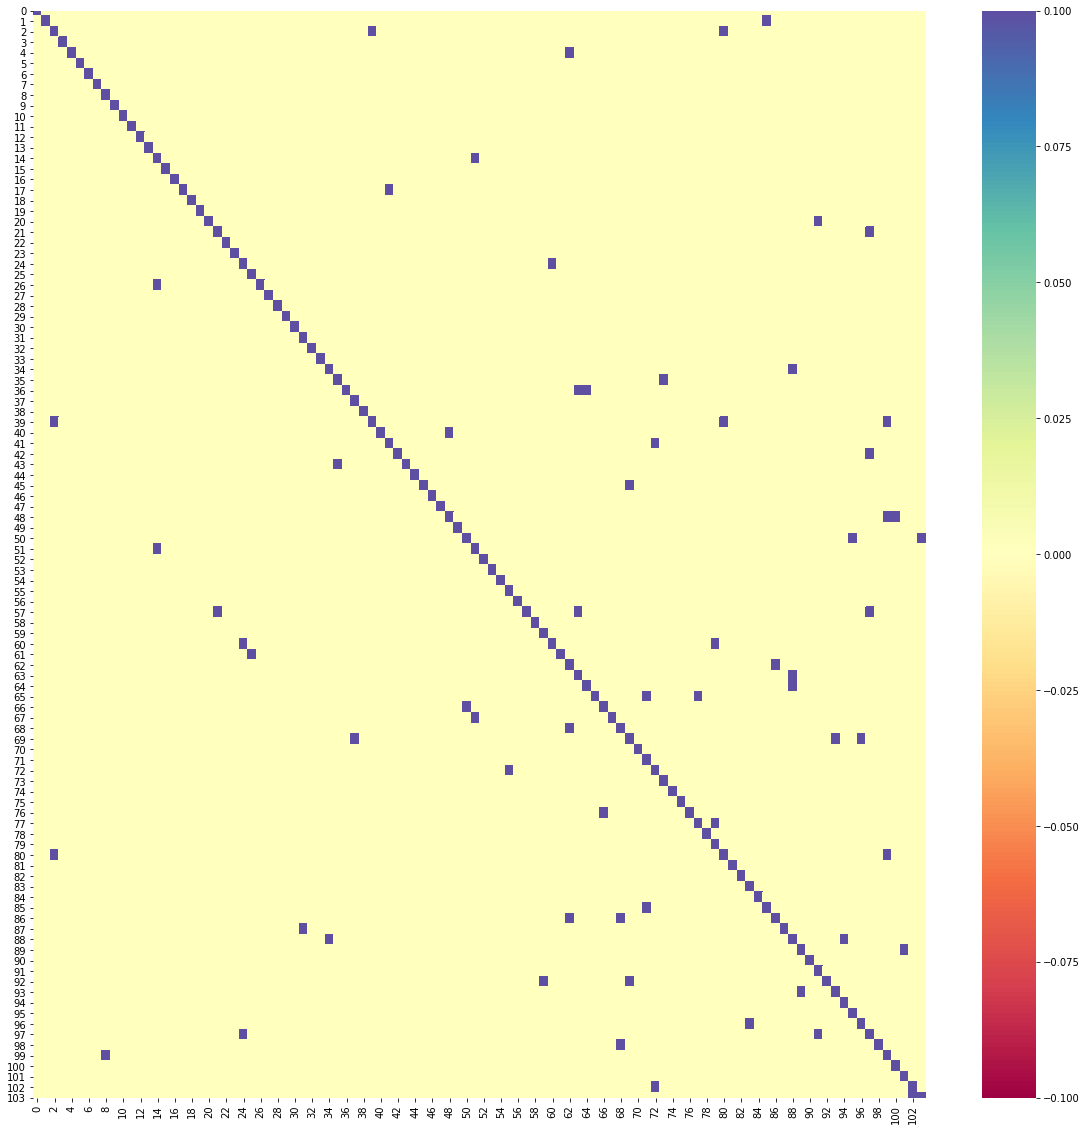

In [26]:
# Spectral Color Map used: Violet means 1, Red means -1 and Yellow means 0
cfs9 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20,20))
sn.heatmap(cfs9, cmap="Spectral", robust=True)

#### Multiclass Precision, Recall and Accuracy

In [27]:
cr9 = classification_report(y_true, y_pred, digits=4)
print(cr9)

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        16
           1     1.0000    0.8333    0.9091         6
           2     0.7692    0.7692    0.7692        13
           3     1.0000    1.0000    1.0000         6
           4     1.0000    0.8000    0.8889         5
           5     1.0000    1.0000    1.0000         6
           6     1.0000    1.0000    1.0000        12
           7     1.0000    1.0000    1.0000         6
           8     0.9091    1.0000    0.9524        10
           9     1.0000    1.0000    1.0000        10
          10     1.0000    1.0000    1.0000        10
          11     1.0000    1.0000    1.0000        11
          12     1.0000    1.0000    1.0000        12
          13     1.0000    1.0000    1.0000        10
          14     0.6364    0.8750    0.7368         8
          15     1.0000    1.0000    1.0000         7
          16     1.0000    1.0000    1.0000         7
          17     1.0000    

In [28]:
X_test

array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.]]],


       [[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]],


       [[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]],


       ...,


       [[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]